# ASTR 596: FDS Homework 7: Gaussian Processes


### Last week, you worked on finding periodic planet signals in the light curve of Kepler-90, a star that is photometrically stable. The periodogram worked nicely because 

### a) we cleaned the light curve to squelch red noise
### b) the signals really were periodic and we could implictly make a strong assumption about the covariance between points.

### Life gets harder when the star itself has quasi-periodic variations because it has a magnetic field and is rotating (ruh oh...) 

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
tab = Table.read('KIC2157356.txt',format='ascii')
tab['quarter'] = tab['quarter'].astype('int')
tab

time,flux,error,quarter
float64,float64,float64,int64
539.4710179205795,5221.16455078125,4.891251087188721,6
539.4914521464307,5216.07958984375,4.892819404602051,6
539.5118864718097,5225.43359375,4.891888618469238,6
539.5323205971945,5233.111328125,4.892074108123779,6
539.5527548221144,5221.17333984375,4.891964435577393,6
539.573189147035,5220.09521484375,4.891523361206055,6
539.5936232714812,5222.14208984375,4.893854141235352,6
539.6140574957026,5224.57958984375,4.893648147583008,6
539.6344918194518,5223.78564453125,4.894421100616455,6


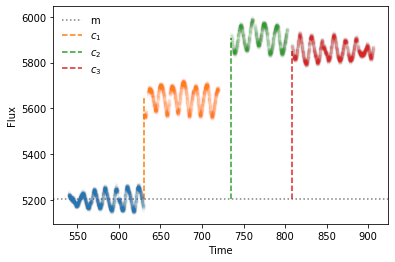

In [2]:
qs = sorted(np.unique(tab['quarter']))
means = []
cycle_map = {}
t_trans= []
for i, q in enumerate(qs):
    ind = tab['quarter']==q
    t = tab[ind]
    plt.errorbar(t['time'],t['flux'], yerr=t['error'], marker='.', linestyle='None', alpha=0.01)
    meanflux = np.mean(t['flux'])
    cycle_map[q] = ind
    means.append(meanflux)
    if i == 0:
        plt.axhline(meanflux, label='m', color='grey', ls=":")
    else:

        vmin = means[0]
        vmax = meanflux
        t_trans.append(t['time'][0])
        plt.plot((t['time'][0], t['time'][0]), (vmin, vmax), label=rf'$c_{i}$', color=f'C{i}', ls='--')     
        
plt.xlabel('Time')
plt.ylabel('Flux')
plt.legend(frameon=False)
plt.show()

### As you can see there is some kind of periodic singal, but it's not perfectly regular. There is also the usual offsets between Kepler photometry in different cycles.

### You'll need four parameters to describe constants ($m, c_1, c_2, c_3$) to renormalize the flux to the first cycle, illustrated in the figure above. 
### $m$ specifies the mean of the Gaussian process, while $c_1, c_2, c_3$ are nuisance parameters. 

### You know how to implement a model with one common zeropoint and multiple offsets - this was what you did on your midterm.


### You'll also need some model to describe the quasi-periodic oscillations. There's no good way to write down a model in real for these in real space because stellar magnetic fields are incredibly complicated. 

### Instead we'll write down a model for the covariance between the observations and use a Gaussian process to model the star. You can model quasi-periodic correlation structure as something periodic + something that varies the periodicity smoothly:

## $$k(t_i, t_j) = A\cdot \exp\left(-\Gamma_1\cdot \sin^2\left(\frac{\pi}{P}|t_i - t_j|\right) -  \frac{|t_i-t_j|^2}{\lambda}) \right) $$

### This is another 4 parameters, ($A, \Gamma_1, P, \lambda$) parameters for a total of 8: ($m, c_1, c_2, c_3, A, \Gamma_1, P, \lambda$)


<hr>

### Q1: To implement the GP correlations, use the `george` package to construct this quasi-periodic kernel
https://george.readthedocs.io/en/latest/user/kernels/


### In particular, you should be able to combine `ExpSine2Kernel` and `ExpSquaredKernel` to get a model for the quasi-periodic oscillations.

In [3]:
import george
from george import kernels

def kernel(A,G1,logP,L):
    return A*kernels.Product(kernels.ExpSine2Kernel(gamma=G1, log_period=logP),kernels.ExpSquaredKernel(metric=L))

Use kernels.Product to combine ExpSine2Kernel and ExpSquaredKernel.

### Q2: To implement the full model, read how to use `george`'s modeling protocol:
https://george.readthedocs.io/en/latest/tutorials/model/

In [4]:
from george.modeling import Model
class mean(Model):
    parameter_names = ("m", "c1", "c2", "c3")
    global t_trans
    def get_value(self, t):
        t = t.flatten()
        mask = {6:(t < t_trans[0]),7:((t >= t_trans[0]) & (t < t_trans[1])),8:((t >= t_trans[1]) & (t < t_trans[2])),9:(t >= t_trans[2])}        
        return mask[6]*self.m + mask[7]*self.c1 + mask[8]*self.c2 + mask[9]*self.c3

Use george's modeling protocol to construct the mean function for GP.

In [5]:
pick = 20
t = tab['time'][::pick]
y = tab['flux'][::pick]
yerr = tab['error'][::pick]
reY = np.zeros(len(y))
for i in range(4):
    reY += cycle_map[i+6][::pick]*(y-means[i])

m,c1,c2,c3 = means
A,G1,logP,L = reY.var(),1,np.log(15),(t.std()/10)**2

model = george.GP(mean=mean(m,c1,c2,c3), kernel=kernel(A,G1,logP,L))
model.compute(t, yerr)

Here use every 20th sample in time. Using every 10th is too computationally expensive for my laptop.

In [6]:
from scipy.optimize import minimize
def nll(p):
    model.set_parameter_vector(p)
    return -model.log_likelihood(y, quiet=True)

p0 = model.get_parameter_vector()
result = minimize(fun = nll, x0 = p0)
peak = result.x
spread = np.diag(result.hess_inv)**0.5
print('Peak   =', peak)
print('Spread =', spread)

Peak   = [5.20775618e+03 5.63135922e+03 5.88605289e+03 5.87884038e+03
 7.62115962e+00 7.23802768e-01 2.64364694e+00 5.33066123e+00]
Spread = [6.93446624 7.27154612 0.20408963 0.21516142 0.00740457 0.02690338
 0.01581625 0.0512169 ]


Locate where the peak of the likelihood is.

### Q3: With your model and likelihood constructured, write down priors on the parameters (you should be able to estimate from the plots)

In [7]:
#import scipy.stats as st
dtmax = tab['time'][-1]-tab['time'][0]
dtmin = (tab['time'][1:]-tab['time'][:-1]).min()
tstd = tab['time'].std()

limits = []
for i in range(4):
    flux = tab['flux'][cycle_map[i+6]]
    limits.append([flux.max(),flux.min(),flux.std()])

limits.append(np.log(np.array([100,0.01,1])*reY.var()))
limits.append([np.log(100),0,np.log(100)])
limits.append(np.log([dtmax,dtmin,tstd]))
limits.append(np.log([dtmax**2,dtmin**2,tstd**2]))
limits = np.array(limits)
limits

array([[ 5.27360205e+03,  5.14421533e+03,  2.99055285e+01],
       [ 5.72667041e+03,  5.55192188e+03,  4.58306201e+01],
       [ 5.99816895e+03,  5.82853027e+03,  4.26929900e+01],
       [ 5.93305615e+03,  5.78434229e+03,  3.35655134e+01],
       [ 1.18654777e+01,  2.65513731e+00,  7.26030750e+00],
       [ 4.60517019e+00,  0.00000000e+00,  4.60517019e+00],
       [ 5.90387847e+00, -3.89063241e+00,  4.70235393e+00],
       [ 1.18077569e+01, -7.78126482e+00,  9.40470787e+00]])

For m, c1, c2, and c3, their value must be bounded in the max and min values in their respective cycles. The variance of the offset flux gives a natural scale for A. 100 and 0.01 times of the variance should reasonably set the prior range for A. I guess $\Gamma_{1}$ could be determined by the relative modulation of the quasi-periodic oscillations. $\log(100)$ seems to be large enough for the upper bound, and 0 should be the lower bound (no quasi-periodic oscillations at all). Finally, P and $\sqrt\lambda$ should be bounded between max$(|t_{i}-t_{j}|)$ and min$(|t_{i}-t_{j}|)$ given by data.

I use normal distribution to model my priors. The sigmas for m, c1, c2, and c3 are set by standard deviations of the offset flux in their respective cycles. The variance of the offset flux gives a natural scale for the sigma of A. Similarly, the standard deviation of time sets the natural scale for sigmas of P and $\sqrt \lambda$. For $\Gamma_{1}$, I don't know if there is a natural scale for the sigma. Therefore, I use its prior range as sigma for $\Gamma_{1}$.

In [8]:
def log_prior(p):
#    m,c1,c2,c3,logA,G1,logP,logL = p
    log_p = np.zeros(8)
    for j in range(8):
#    for j in [0,1,2,3,6,7]:
        limit = limits[j]
        if ((p[j] > limit[0]) or (p[j] < limit[1])):
            return -np.inf
        else:
            log_p[j] = -0.5*((p[j]-peak[j])/(5*limit[2]))**2

    return log_p.sum()

def lnprob(p):
    model.set_parameter_vector(p)
    return model.log_likelihood(y, quiet=True) + log_prior(p)

Building up the log-posterior function for emcee.

### Q4: Use `emcee` to optimize the model parameters and hyper-parameters, **using only every 10th sample in time**
### (Don't go overboard with the number of walkers or steps)
https://george.readthedocs.io/en/latest/tutorials/hyper/ may help

In [9]:
import scipy.stats as st
import emcee
nwalkers, ndim = 2*len(model), len(model)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

p0 = st.norm.rvs(loc=peak, scale=3*spread, size=(nwalkers,ndim))

nburn = 500
nsamp = 1000
_ = sampler.run_mcmc(p0, nburn+nsamp)

Hoping that my numbers of walkers and steps aren't going overboard.

In [10]:
thin = 10
sample = sampler.chain[:, nburn:, :].reshape(-1, ndim)
sample = sample[::thin,:]

Discard the burn-in and thin the samples by 10.

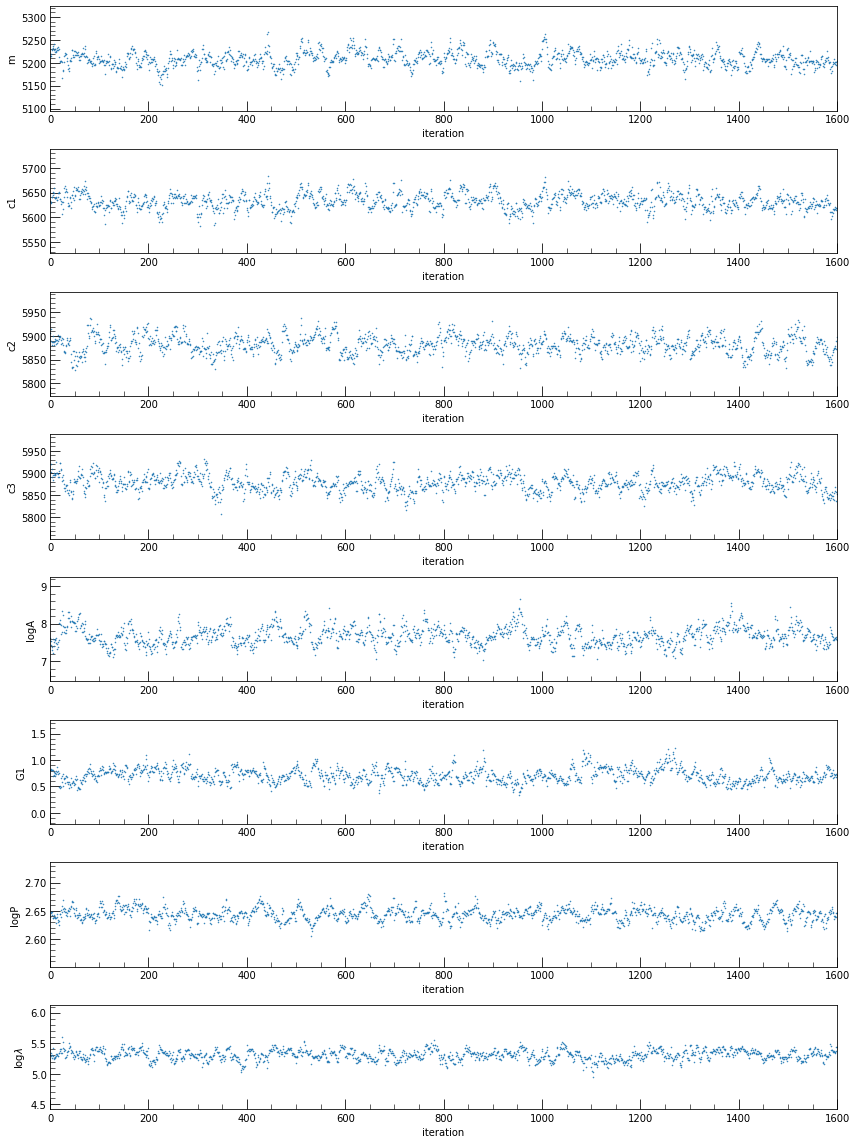

In [11]:
ylabels = ['m','c1','c2','c3','logA','G1','logP',r'log$\lambda$']
from matplotlib.ticker import AutoMinorLocator
fig = plt.figure(figsize=(12,16))
for i in range(ndim):
    ax = fig.add_subplot(ndim,1,i+1)
    ax.plot(sample[:,i],ls='',marker='.',ms=1)
    ax.set_xlabel(f'iteration')
    ax.set_ylabel(ylabels[i])
    ymin,ymax = ax.get_ylim()
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which='major', length=10,direction ='in')
    ax.tick_params(which='minor', length=5,direction ='in')
    ax.set_xlim([0,nsamp*nwalkers/thin])
    if (i < 4):
        ax.set_ylim([ymin-50,ymax+50])       
    elif (i == 6):
        ax.set_ylim([ymin-0.05,ymax+0.05])
    else:
        ax.set_ylim([ymin-0.5,ymax+0.5])

fig.tight_layout()
plt.show()

These trace plots are looking good.

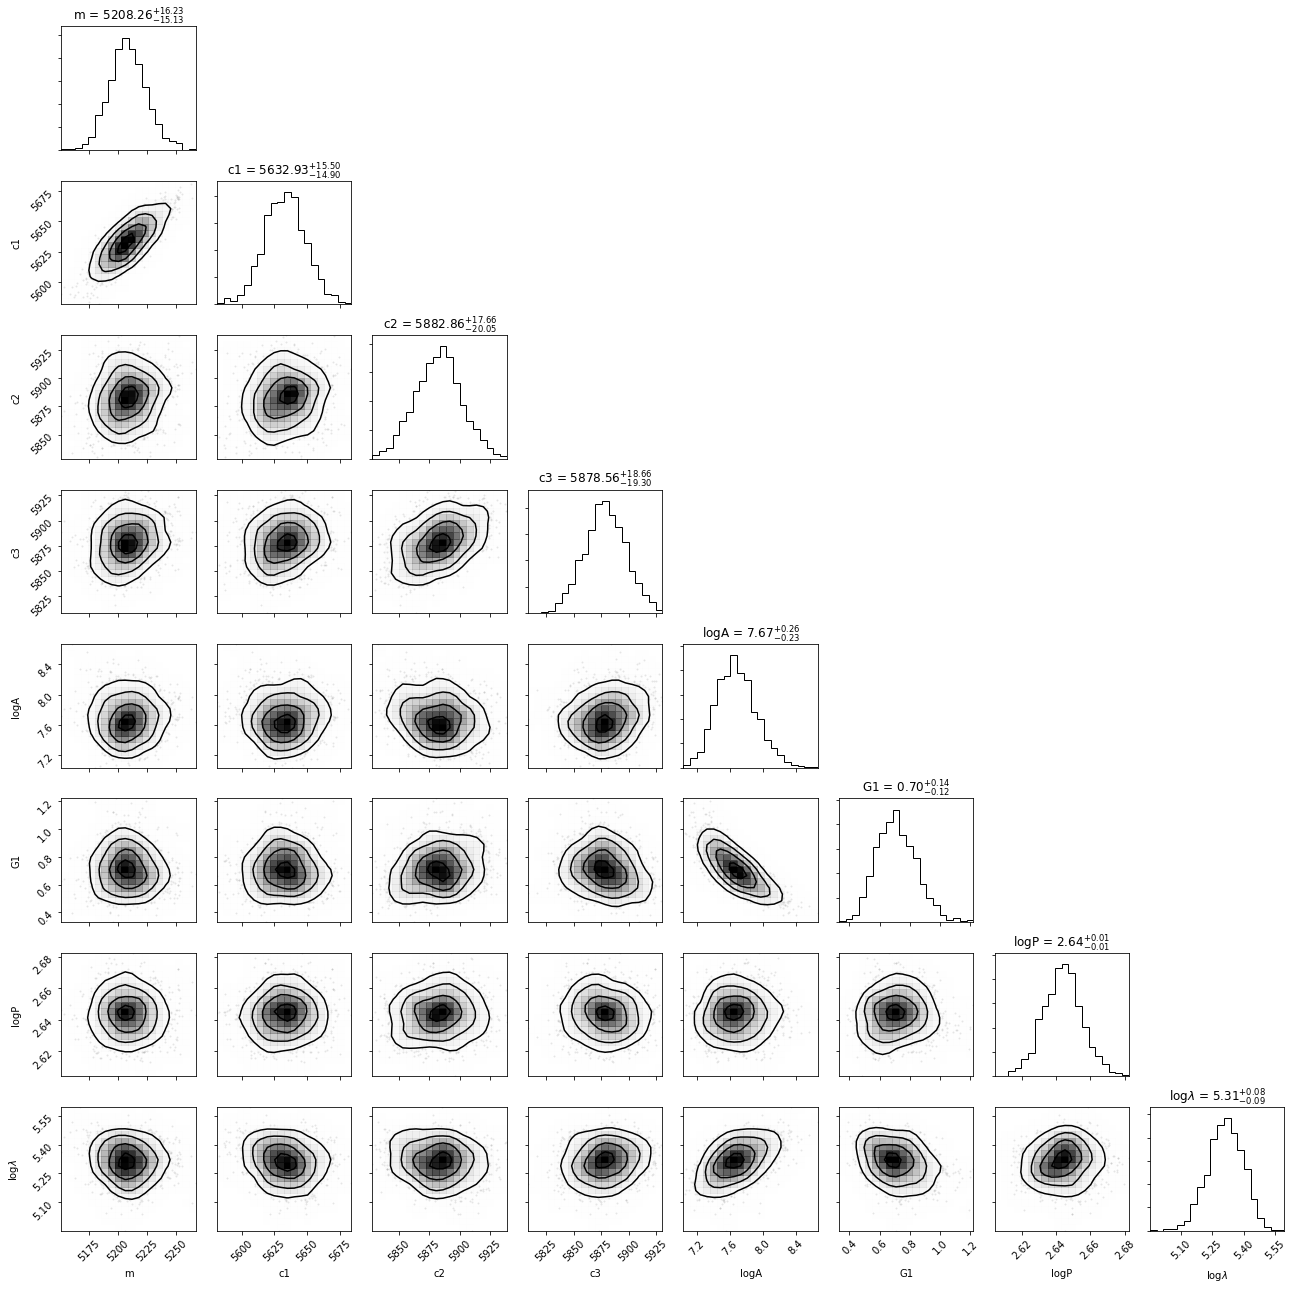

In [12]:
import corner
fig = corner.corner(sample,labels=ylabels, plot_contours=True, show_titles=True, smooth=1)
fig.tight_layout()
plt.show()

The corner plot is also looking good.

### Q5: Plot your posterior model over the data after correcting for the offsets, showing the points you used to condition the GP in red, and the remaining data in black. 

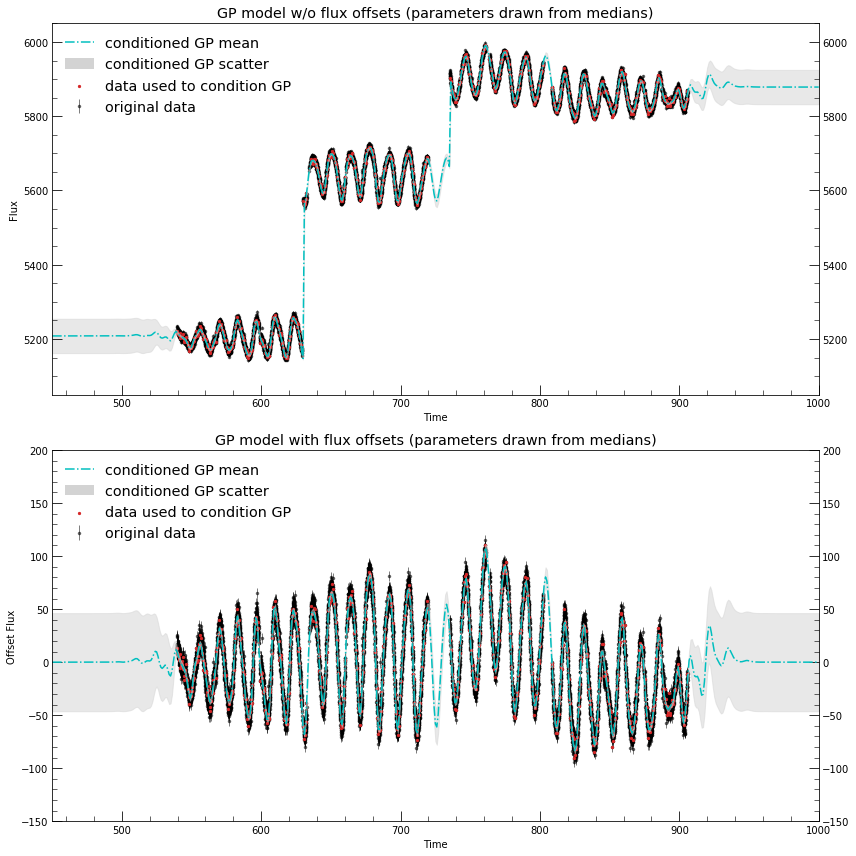

In [13]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
line2 = Line2D([0], [0], color='c', lw=1.5,ls='-.')
patch = Patch(facecolor='lightgrey')
fig, ax = plt.subplots(2,figsize=(12,12))
ylim = [[5050,6050],[-150,200]]
ylabel = ['Flux','Offset Flux']
title = ['GP model w/o flux offsets','GP model with flux offsets']
llabels = ['conditioned GP mean','conditioned GP scatter','data used to condition GP','original data']
t_new = np.linspace(450, 1000, 551)
stats = np.percentile(sample, [50, 16, 84], axis=0)

p0 = stats[0]
model.set_parameter_vector(p0)
ypred, cov = model.predict(y, t_new, return_cov=True)
std = np.sqrt(np.diag(cov))
td = tab['time']
yd = [tab['flux'],tab['flux']-model.mean.get_value(td)]
yp = [y,y-model.mean.get_value(t)]
ypred = [ypred, ypred-model.mean.get_value(t_new)]

for i in range(2):
    line0 = ax[i].errorbar(td,yd[i], yerr=tab['error'],color='k', marker='.',ms = 5,alpha=0.5,elinewidth = 1, linestyle='None',zorder=0)
    line1 = ax[i].scatter(t, yp[i], color='C3', marker='o',s=5)
    ax[i].plot(t_new, ypred[i], 'c', ls='-.', lw=1.5)
    ax[i].fill_between(t_new, ypred[i]-std, ypred[i]+std, color='lightgrey',alpha = 0.5)
    ax[i].set_xlim([t_new[0],t_new[-1]])
    ax[i].set_ylim(ylim[i])
    ax[i].xaxis.set_minor_locator(AutoMinorLocator())
    ax[i].yaxis.set_minor_locator(AutoMinorLocator())
    ax[i].tick_params(which='major', length=10,direction ='in',right=True,labelright=True)
    ax[i].tick_params(which='minor', length=5,direction ='in',right=True,labelright=True)
    ax[i].set_xlabel('Time')
    ax[i].set_ylabel(ylabel[i])
    ax[i].set_title(title[i]+' (parameters drawn from medians)',fontsize='x-large')
    ax[i].legend([line2,patch,line1,line0],llabels,frameon=False,loc = 'upper left',fontsize='x-large')
    
fig.tight_layout()
plt.show()

Plot the GP model over the data with GP parameters drawn from medians of the MCMC chain.

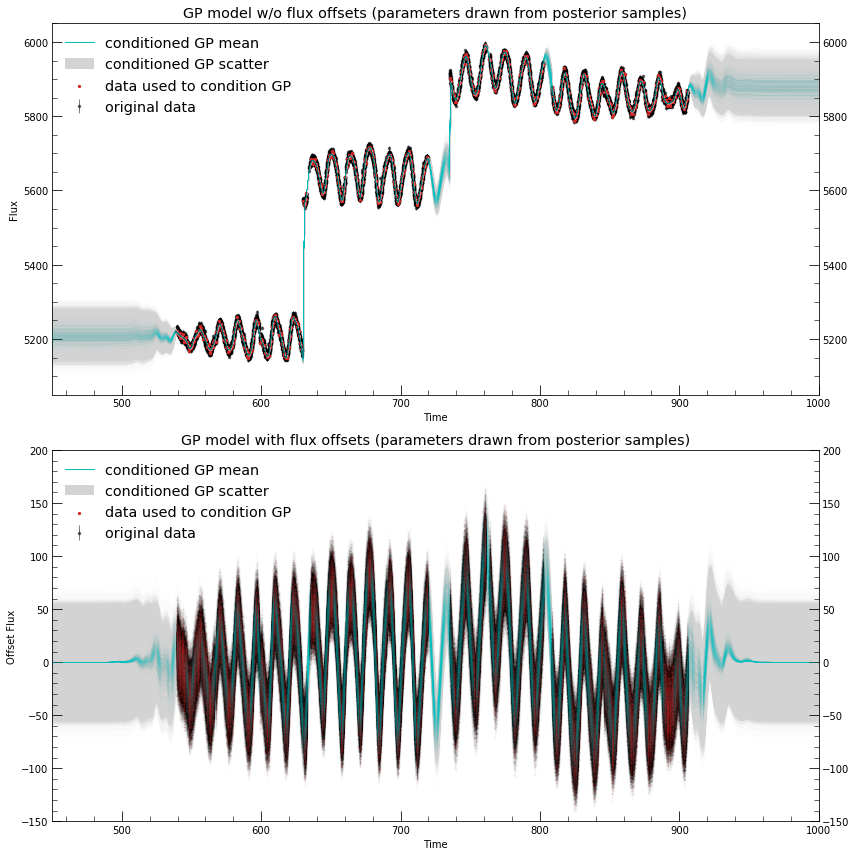

In [14]:
fig, axes = plt.subplots(2,figsize=(12,12))
shift = nwalkers*nsamp/thin
line2 = Line2D([0], [0], color='c', lw=1,ls='-')

for i in range(2):
    ax = axes[i]
    if (i == 0):
        line0 = ax.errorbar(tab['time'],tab['flux'], yerr=tab['error'],color='k', marker='.',ms = 5,alpha=0.5,elinewidth = 1, linestyle='None',zorder=0)
        line1 = ax.scatter(t, y, color='C3', marker='o',s=5)

    for j,p in enumerate(sample[::5]):
        model.set_parameter_vector(p)
        ypred, cov = model.predict(y, t_new, return_cov=True)
        std = np.sqrt(np.diag(cov))

        if (i == 1):
            ax.errorbar(tab['time'],tab['flux']-model.mean.get_value(td), yerr=tab['error'],color='k', marker='.',ms = 2,alpha=0.01,elinewidth = 0.1, linestyle='None',zorder=j)
            ax.scatter(t, y-model.mean.get_value(t), color='C3', marker='o',s=1,alpha = 0.04,zorder = shift+j)
            ypred = ypred-model.mean.get_value(t_new)
            
        ax.fill_between(t_new, ypred-std, ypred+std, color='lightgrey',alpha = 0.01)
        ax.plot(t_new, ypred, 'c', ls='-',lw=0.1, alpha = 0.1,zorder = 2*shift+j)

    ax.set_xlim([t_new[0],t_new[-1]])
    ax.set_ylim(ylim[i])
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which='major', length=10,direction ='in',right=True,labelright=True)
    ax.tick_params(which='minor', length=5,direction ='in',right=True,labelright=True)
    ax.set_xlabel('Time')
    ax.set_ylabel(ylabel[i])
    ax.set_title(title[i]+' (parameters drawn from posterior samples)',fontsize='x-large')
    ax.legend([line2,patch,line1,line0],llabels,frameon=False,loc = 'upper left',fontsize='x-large')
    
fig.tight_layout()
plt.show()

Plot the GP model over the data with GP parameters drawn from the posterior samples.